# Chatbot with Collection Schema 

## Review

We extended our chatbot to save semantic memories to a single [user profile](https://docs.langchain.com/oss/python/concepts/memory#profile). 

We also introduced a library, [Trustcall](https://github.com/hinthornw/trustcall), to update this schema with new information. 

## Goals

Sometimes we want to save memories to a [collection](https://docs.google.com/presentation/d/181mvjlgsnxudQI6S3ritg9sooNyu4AcLLFH1UK0kIuk/edit#slide=id.g30eb3c8cf10_0_200) rather than single profile. 

Here we'll update our chatbot to [save memories to a collection](https://docs.langchain.com/oss/python/concepts/memory#collection).

We'll also show how to use Trustcall to update this collection. 


In [ ]:
%%capture --no-stderr
%pip install -U langchain_openai langgraph trustcall langchain_core

In [1]:
import uuid
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.store.memory import InMemoryStore
from trustcall import create_extractor
from IPython.display import Image, display
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.store.memory import InMemoryStore
from langchain_core.messages import merge_message_runs
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.runnables.config import RunnableConfig
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.base import BaseStore

In [2]:
import os, getpass

def _set_env(var: str):
    # Check if the variable is set in the OS environment
    env_value = os.environ.get(var)
    if not env_value:
        # If not set, prompt the user for input
        env_value = getpass.getpass(f"{var}: ")
    
    # Set the environment variable for the current process
    os.environ[var] = env_value

_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

## Defining a collection schema

Instead of storing user information in a fixed profile structure, we'll create a flexible collection schema to store memories about user interactions.

Each memory will be stored as a separate entry with a single `content` field for the main information we want to remember

This approach allows us to build an open-ended collection of memories that can grow and change as we learn more about the user.

We can define a collection schema as a [Pydantic](https://docs.pydantic.dev/latest/) object. 

In [32]:
class Memory(BaseModel):
    content: str = Field(
        description="The main content of the memory. For example: User expressed interest in learning about French."
        )

class MemoryCollection(BaseModel):
    memories: list[Memory] = Field(
        description="A list of memories associated with the user."
        )

In [33]:
_set_env("OPENAI_API_KEY")

We can used LangChain's chat model  [chat model](https://docs.langchain.com/oss/python/langchain/models) interface's [`with_structured_output`](https://docs.langchain.com/oss/python/langchain/models#structured-outputs) method to enforce structured output.

In [34]:
# Initialize the model
model = ChatOpenAI(model="gpt-4o", temperature=0)

# Bind schema to model
model_with_structure = model.with_structured_output(MemoryCollection)

# Invoke the model to produce structured output that matches the schema
memory_collection = model_with_structure.invoke([HumanMessage("My name is Umer. I like to bike.")])

In [35]:
memory_collection.memories

[Memory(content="User's name is Umer."), Memory(content='User likes to bike.')]

We can use `model_dump()` to serialize a Pydantic model instance into a Python dictionary.

In [36]:
memory_collection.memories[0].model_dump()

{'content': "User's name is Umer."}

Save dictionary representation of each memory to the store. 

In [37]:
# Initialize the in-memory store
in_memory_store = InMemoryStore()

# Namespace for the memory to save
user_id = "1"
namespace = (user_id, "memories")

# Save a memory to namespace as key and value
key = str(uuid.uuid4())
value = memory_collection.memories[0].model_dump()
in_memory_store.put(namespace, key, value)

key = str(uuid.uuid4())
value = memory_collection.memories[1].model_dump()
in_memory_store.put(namespace, key, value)

Search for memories in the store. 

In [38]:
# Search 
for m in in_memory_store.search(namespace):
    print(m)

Item(namespace=['1', 'memories'], key='74b5144b-9a0f-46d5-8cef-45dc6b0abdd3', value={'content': "User's name is Umer."}, created_at='2025-12-28T11:32:56.270433+00:00', updated_at='2025-12-28T11:32:56.270437+00:00', score=None)
Item(namespace=['1', 'memories'], key='e4f2946a-75a2-474a-8d2a-3ecc380c02a7', value={'content': 'User likes to bike.'}, created_at='2025-12-28T11:32:56.270855+00:00', updated_at='2025-12-28T11:32:56.270859+00:00', score=None)


In [54]:
mems = in_memory_store.search(namespace)
mems

[Item(namespace=['1', 'memories'], key='74b5144b-9a0f-46d5-8cef-45dc6b0abdd3', value={'content': "User's name is Umer."}, created_at='2025-12-28T11:32:56.270433+00:00', updated_at='2025-12-28T11:32:56.270437+00:00', score=None),
 Item(namespace=['1', 'memories'], key='e4f2946a-75a2-474a-8d2a-3ecc380c02a7', value={'content': 'User likes to bike.'}, created_at='2025-12-28T11:32:56.270855+00:00', updated_at='2025-12-28T11:32:56.270859+00:00', score=None)]

In [57]:
for m in mems:
    print(m.value['content'])

User's name is Umer.
User likes to bike.


## Updating collection schema

We discussed the challenges with updating a profile schema in the last lesson. 

The same applies for collections! 

We want the ability to update the collection with new memories as well as update existing memories in the collection. 

Now we'll show that [Trustcall](https://github.com/hinthornw/trustcall) can be also used to update a collection. 

This enables both addition of new memories as well as [updating existing memories in the collection](https://github.com/hinthornw/trustcall?tab=readme-ov-file#simultanous-updates--insertions
).

Let's define a new extractor with Trustcall. 

As before, we provide the schema for each memory, `Memory`.  

But, we can supply `enable_inserts=True` to allow the extractor to insert new memories to the collection. 

In [39]:
# Create the extractor
trustcall_extractor = create_extractor(
    llm=model,
    tools=[Memory],
    tool_choice="Memory",
    enable_inserts=True
)

In [41]:
# Instruction
instruction = """Extract memories from the following conversation:"""

# Conversation
conversation = [HumanMessage(content="Hi, I'm Umer."), 
                AIMessage(content="Nice to meet you, Umer."), 
                HumanMessage(content="This morning I had a nice bike ride in San Francisco.")]

# Invoke the extractor
result = trustcall_extractor.invoke({"messages": [SystemMessage(content=instruction)] + conversation})

In [42]:
# Messages contain the tool calls
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Memory (call_YlnBVVE38NBueH9qiBkpP9ov)
 Call ID: call_YlnBVVE38NBueH9qiBkpP9ov
  Args:
    content: Umer had a nice bike ride in San Francisco this morning.


In [43]:
# Responses contain the memories that adhere to the schema
for m in result["responses"]: 
    print(m)

content='Umer had a nice bike ride in San Francisco this morning.'


In [44]:
# Metadata contains the tool call  
for m in result["response_metadata"]: 
    print(m)

{'id': 'call_YlnBVVE38NBueH9qiBkpP9ov'}


In [45]:
# Update the conversation
updated_conversation = [AIMessage(content="That's great, did you do after?"), 
                        HumanMessage(content="I went to Tartine and ate a croissant."),                        
                        AIMessage(content="What else is on your mind?"),
                        HumanMessage(content="I was thinking about my Japan, and going back this winter!"),]

# Update the instruction
system_msg = """Update existing memories and create new ones based on the following conversation:"""

In [46]:
tool_name = "Memory"
existing_memories = [
        (str(i), tool_name, memory.model_dump()) for i, memory in enumerate(result["responses"])
    ] if result["responses"] else None

existing_memories

[('0',
  'Memory',
  {'content': 'Umer had a nice bike ride in San Francisco this morning.'})]

In [ ]:
# Invoke the extractor with our updated conversation and existing memories
result = trustcall_extractor.invoke({"messages": updated_conversation, "existing": existing_memories})

In [48]:
# Messages from the model indicate two tool calls were made
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Memory (call_HqyZq9UoHAz5057MWVkdjAg4)
 Call ID: call_HqyZq9UoHAz5057MWVkdjAg4
  Args:
    content: Umer had a nice bike ride in San Francisco this morning. Then, he went to Tartine and ate a croissant. He was also thinking about Japan and going back this winter.
  Memory (call_OCsjo3DPNk3qUMy0xljqczM0)
 Call ID: call_OCsjo3DPNk3qUMy0xljqczM0
  Args:
    content: Umer went to Tartine and ate a croissant. He was also thinking about Japan and going back this winter.


In [49]:
# Responses contain the memories that adhere to the schema
for m in result["responses"]: 
    print(m)

content='Umer had a nice bike ride in San Francisco this morning. Then, he went to Tartine and ate a croissant. He was also thinking about Japan and going back this winter.'
content='Umer went to Tartine and ate a croissant. He was also thinking about Japan and going back this winter.'


In [50]:
# Metadata contains the tool call  
for m in result["response_metadata"]: 
    print(m)

{'id': 'call_HqyZq9UoHAz5057MWVkdjAg4', 'json_doc_id': '0'}
{'id': 'call_OCsjo3DPNk3qUMy0xljqczM0'}


In [51]:
existing_memories = [
        (str(i), memory.model_dump()) for i, memory in enumerate(result["responses"])
    ] if result["responses"] else None

existing_memories

[('0',
  {'content': 'Umer had a nice bike ride in San Francisco this morning. Then, he went to Tartine and ate a croissant. He was also thinking about Japan and going back this winter.'}),
 ('1',
  {'content': 'Umer went to Tartine and ate a croissant. He was also thinking about Japan and going back this winter.'})]

This tells us that we updated the first memory in the collection by specifying the `json_doc_id`. 

LangSmith trace: 

https://smith.langchain.com/public/ebc1cb01-f021-4794-80c0-c75d6ea90446/r

## Chatbot with collection schema updating

Now, let's bring Trustcall into our chatbot to create and update a memory collection.

In [52]:
# Initialize the model
model = ChatOpenAI(model="gpt-4o", temperature=0)

# Memory schema
class Memory(BaseModel):
    content: str = Field(
        description="The main content of the memory. For example: User expressed interest in learning about French."
        )

# Create the Trustcall extractor
trustcall_extractor = create_extractor(
    llm=model,
    tools=[Memory],
    tool_choice="Memory",
    enable_inserts=True    # This allows the extractor to insert new memories
)

In [53]:
# Chatbot instruction
MODEL_SYSTEM_MESSAGE = """
    You are a helpful chatbot. You are designed to be a companion to a user. 
    You have a long term memory which keeps track of information you learn about the user over time.
    Current Memory (may include updated memories from this conversation): {memory}
"""

# Trustcall instruction
TRUSTCALL_INSTRUCTION = """
    Reflect on following interaction. 
    Use the provided tools to retain any necessary memories about the user. 
    Use parallel tool calling to handle updates and insertions simultaneously:
"""

In [64]:
def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Load memories from the store and use them to personalize the chatbot's response."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve memory from the store
    namespace = ("memories", user_id)
    memories = store.search(namespace)

    # Format the memories for the system prompt
    info = "\n".join(f"- {mem.value['content']}" for mem in memories)
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=info)

    # Respond using memory as well as the chat history
    response = model.invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": response}

In [65]:
def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and update the memory collection."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Define the namespace for the memories
    namespace = ("memories", user_id)

    # Retrieve the most recent memories for context
    existing_items = store.search(namespace)

    # Format the existing memories for the Trustcall extractor
    tool_name = "Memory"
    existing_memories = ([(existing_item.key, tool_name, existing_item.value)
                          for existing_item in existing_items]
                          if existing_items
                          else None
                        )

    # Merge the chat history and the instruction
    updated_messages=list(merge_message_runs(messages=[SystemMessage(content=TRUSTCALL_INSTRUCTION)] + state["messages"]))

    # Invoke the extractor
    result = trustcall_extractor.invoke({"messages": updated_messages, 
                                        "existing": existing_memories})

    # Save the memories from Trustcall to the store
    for r, rmeta in zip(result["responses"], result["response_metadata"]):
        store.put(namespace,
                  rmeta.get("json_doc_id", str(uuid.uuid4())),
                  r.model_dump(mode="json"),
            )

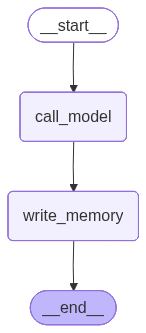

In [66]:
# define the graph
graph_builder = StateGraph(MessagesState)

# Add graph nodes
graph_builder.add_node("call_model", call_model)
graph_builder.add_node("write_memory", write_memory)

# Define the graph edges
graph_builder.add_edge(START, "call_model")
graph_builder.add_edge("call_model", "write_memory")
graph_builder.add_edge("write_memory", END)

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# Build the graph
graph = graph_builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# Display the graph
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [67]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="Hi, my name is Lance")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is Lance
================================== Ai Message ==================================

Hi Lance! It's great to meet you. How can I assist you today?


In [68]:
# User input 
input_messages = [HumanMessage(content="I like to bike around San Francisco")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I like to bike around San Francisco
================================== Ai Message ==================================

That sounds like a lot of fun! San Francisco has some beautiful routes for biking. Do you have a favorite trail or area you like to explore?


In [69]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memories", user_id)
memories = across_thread_memory.search(namespace)
for m in memories:
    print(m.dict())

{'namespace': ['memories', '1'], 'key': 'd0f6c3d4-b4ad-4583-8e33-7d80c23ba711', 'value': {'content': "User's name is Lance."}, 'created_at': '2025-12-28T16:30:53.816822+00:00', 'updated_at': '2025-12-28T16:30:53.816823+00:00', 'score': None}
{'namespace': ['memories', '1'], 'key': '5c7d3674-4ef3-478f-983f-8115562010f3', 'value': {'content': 'User likes to bike around San Francisco.'}, 'created_at': '2025-12-28T16:30:57.659127+00:00', 'updated_at': '2025-12-28T16:30:57.659130+00:00', 'score': None}


In [70]:
# User input 
input_messages = [HumanMessage(content="I also enjoy going to bakeries")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I also enjoy going to bakeries
================================== Ai Message ==================================

That sounds delightful! San Francisco has some amazing bakeries. Do you have a favorite bakery or a type of pastry you enjoy the most?


In [71]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "2", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="What bakeries do you recommend for me?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

What bakeries do you recommend for me?
================================== Ai Message ==================================

Since you enjoy biking around San Francisco, you might want to check out a few bakeries that are not only delicious but also conveniently located for a nice ride. Here are some recommendations:

1. **Tartine Bakery** - Located in the Mission District, it's famous for its bread and pastries. It's a great spot to stop by after a ride through the vibrant neighborhood.

2. **Arsicault Bakery** - Known for its amazing croissants, this bakery in the Richmond District is perfect for a treat after biking through Golden Gate Park.

3. **B. Patisserie** - Situated in Lower Pacific Heights, this bakery offers a variety of pastries and is a nice stop after exploring the nearby Presidio.

4. **Mr. Holmes Bakehouse** - In the Tenderloin, this spot is famous for its cruffins and other creative pastrie

Continue the conversation in a new thread.

### LangSmith 

https://smith.langchain.com/public/c87543ec-b426-4a82-a3ab-94d01c01d9f4/r

## Studio

![Screenshot 2024-10-30 at 11.29.25 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/6732d0876d3daa19fef993ba_Screenshot%202024-11-11%20at%207.50.21%E2%80%AFPM.png)